# Genre-ator: a classification and captioning system that classifies a movie poster in a genre (from a limited number of genres) and attempts to describe elements in the image
### By: Manasi Sharma (ms5510) and Jetasri Gupta (jg3909)

### Introduction
Movies are a significant part of the current entertainment industry-- Hollywood produces over 700 films per year on average[1]. However, Movie genre classification has been a relatively uncommon project in the AI community so far (the most prominent movie classification project we could find was this paper [2] published in June of this year). Conversely, given the growing state of on-demand streaming services, movie genre classification based on movie posters has the potential to quickly gain traction in recommendation and sales systems. Movie posters can also tell us much about the emotional content of the film and hint at interesting plotlines.

<img src="embedded_imgs/endgame.jpg" style="width: 200px;"/> <img src="embedded_imgs/notebook.jpg" style="width: 200px;"/> <img src="embedded_imgs/annabelle.jpg" style="width: 200px;">

_Three very different kinds of movies_

We aim to train a deep learning classifier to predict the movie genre of a film based on its movie poster. We would also like to go one step forward and attempt to caption the elements in the image, which can help visually-impaired people by translating the poster’s material to other forms (eg. audio, braille, etc.). This sort of analysis can be applied to other media in the future, where an image can be used to gauge the aesthetic qualities and emotions it represents, such as TV shows, Youtube video thumbnails, Song albums, etc. 

Tackling this problem comes with its fair share of challenges-- Posters tend to be complex and stylized images, where several design conventions like color scheme, composition and size of subjects are followed for each genre. This makes such a classification task much more difficult than simple dog-cat classification for example. Also, given the fact that there are numerous movie genres, this task usually involves a more complex multi-class classification than binary classification. Furthermore, movie genres often overlap (eg. romantic comedy), which makes single-class classification somewhat reductive. However, challenges are exciting, and we are enthused to see what we might find! 

### Objectives:
1. To formulate a dataset of movie poster images
2. To be able to classify movie posters into genres, starting with binary classification between 2 genres, then moving to 4 genres, and finally moving to all 6 genres. Goal: to reach at least 50-60% accuracy on all 6 genres.
2. For classification: to compare the performance of various pre-trained deep learning models (since the training set is relatively small). Models chosen: Resnet-18, Resnet-101, VGG-16, AlexNet, VGG-Face (trained on Faces, taken from ModelZoo) and a simple CNN architechture.
3. To attempt basic image captioning by training on an external generic dataset and applying it to the movie posters.
3. At the end, to discuss what did and did not go well, and why.

### Division of tasks: 
1. Code for creating dataset: Manasi, task of downloading the various genre images: Jetasri + Manasi
2. Code for cleaning of directories: Jetasri + Manasi
3. Code for classification and comparisons: Manasi
4. Code for Flikr dataset basic image captioning (and second notebook for training the model): Manasi
6. Code for COCO Image captioning: Jetasri
5. Code for ImageBert: Jetasri

### Reference for trained models:

For training on the 6-genre training set, the models for the 5 networks are named:
1. Resnet-18: checkpoint_resnet18_0.40.pth.tar
2. Resnet-101: checkpoint_resnet101_0.45.pth.tar
3. VGG-16: checkpoint_vgg16_0.42.pth.tar
4. AlexNet: checkpoint_alexnet_0.41.pth.tar
5. VGG-FACE: vgg_face.h5

For training on the 4-genre training set, the models for the 2 networks are named:
1. Resnet-18: checkpoint_resnet18_4_0.56.pth.tar
2. Resnet-101: checkpoint_resnet101_4_0.59.pth.tar

For training on the 2-genre training set, the models for the 2 networks are named:
1. Resnet-18 (frozen): checkpoint_resnet18_2_0.81.pth.tar
2. Resnet-18 (unfrozen): checkpoint_2_resnet18_unfrozen_0.83.pth.tar
2. Resnet-101: checkpoint_resnet101_2_0.84.pth.tar

### Link to presentation video: 
https://youtu.be/oizhv2isoic

# 1. Creating the dataset

We created a dataset of movie posters from scratch. We did this by first web-scraping movie titles from different genres from IMDb. IMDb often lists the "Top xxxx" number of movies above a certain rating theshold, so we utilized the links from various web-pages from different genres:

1. Romance: https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=romance&sort=user_rating,desc&start={q}&ref_=adv_nxt
2. Horror: https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=horror&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt
3. Comedy: https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=comedy&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt
4. Thriller: https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=thriller&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt
5. Documentary: https://www.imdb.com/search/title/?num_votes=1000,&sort=user_rating,desc&title_type=documentary
6. Sci-fi: https://www.imdb.com/search/title/?genres=sci-fi&title_type=feature&sort=user_rating,desc

I utilized code from my first HW1 to scrape the page for the movie title and year, and compiled a list of strings of movie title + year (to ensure the movie poster comes up, as opposed to a still). We then used Selenium [3] to connect to the browser and download images from Google Images by searching up the produced movie search terms. We heavily utilized this section of code suggested by a user ('sufiyaan bhura') on StackOverflow [4], with adjustments to suit the way in which we wanted the downloaded images organized. Jetasri and I split the downloading of genres between ourselves, taking ~4 hours for 1000 images in 1 genre.

We ended up 4969 images in our dataset with the breakdown as follows:

1. Romance: 902
2. Horror: 809
3. Comedy: 565
4. Thriller: 736
5. Documentary: 1038
6. Sci-fi: 1030

Many of these were duplicates, so we made a decision to switch the duplicated images entirely to one genre label or the other (we did not engage in multi-label classification in this project for lack of time unfortunately, but). Eg. Romantic comedies --> Romance, Sci-fi thrillers --> Sci-fi. This unfortunately led to a huge reduction in our training image size (we began with ~1100 images per class). Therefore, We also increased the size of the dataset through implementing dataset augmentation in Pytorch, with transforms such as horizontal and vertical flips, shears, etc.

__Note: The dataset creation and cleaning up was done in a separate notebook, so I have included the code snippets here and screenshots of important output. The rest of the work was done in this notebook (on GCP).__

### Scraping images from IMDb

In [2]:
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
import PIL
import selenium
from selenium import webdriver
import os
import time

In [ ]:
DRIVER_PATH = 'C:/Users/99man/PYTHON_PROJECTS/DL for CV_Fall 2020/project/chromedriver'
wd = webdriver.Chrome(executable_path=DRIVER_PATH)

In [ ]:
def scroll_to_end(wd):
    wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(sleep_between_interactions)

In [ ]:
# drawn heavily from https://stackoverflow.com/questions/37184173/how-to-scrape-the-images-from-the-website
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    #print("max_links_to_fetch: ", max_links_to_fetch)
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = 5 #len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        results_start = len(thumbnail_results)

    return image_urls

In [ ]:
def persist_image(folder_path:str, url:str, search_term:str, counter):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        #f = open(os.path.join(folder_path, 'jpg' + "_" + str(counter) + ".jpg"), 'wb')
        img_save_path= os.path.join(folder_path, '_'.join(search_term.split(' ')) + ".jpg")
        #print("img_save_path: ", img_save_path)
        f = open(img_save_path, 'wb')
        f.write(image_content)
        f.close()
        print(f"SUCCESS - saved {url} - as {folder_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [ ]:
def search_and_download(movie_name: str, movie_year: str, driver_path: str, target_path='./images', 
number_images=1):
    """target_folder = os.path.join(target_path, '_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)"""
    
    search_term= movie_name+' '+movie_year

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, 
sleep_between_interactions=0.5)

    counter = 0
    
    if res is not None:
        for elem in res:
            persist_image(target_path, elem, search_term, counter)
            counter += 1

In [ ]:
genre2url= {'romance': 'https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=romance&sort=user_rating,desc&start={q}&ref_=adv_nxt',
            'horror': 'https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=horror&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt',
            'comedy': 'https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=comedy&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt',
            'thriller': 'https://www.imdb.com/search/title/?title_type=feature&num_votes=10000,&genres=thriller&languages=en&sort=user_rating,desc&start={q}&explore=genres&ref_=adv_nxt'}

In [ ]:
for key, val in genre2url.items():
    print(key)
    print(val)

In [ ]:
gen_num= 0
entries=1002

for genre, url_orig in genre2url.items():
    """if(gen_num == 1): # only because I want to produce images for the first 2 genres only
        pass
    else:
        gen_num += 1
        continue"""
    
    print("GENRE: ", genre)
    print()

    start_num= 551
    
    # code starts
    while(start_num <= entries):
        print("START NUM: ", start_num)
        print()
        
        url= url_orig.format(q=str(start_num))
        print("url: ", url)
        r = requests.get(url)
        bs = BeautifulSoup(r.text)
        llist = bs.find_all('h3',{'class':'lister-item-header'})

        # generate list of all titles and years the films were released
        titles= []
        for x in llist:
            for y in x.find_all('a'):
                titles.append(y.text)
        print(len(titles))
        print(titles)

        years= []
        for x in llist:
            for y in x.find_all('span'):
                if '(' in y.text:
                    years.append(y.text[1:5])
        print(len(years))
        print(years)

        assert(len(titles) == len(years))

        # generating the images for the list of 50 images
        for i in range(len(titles)):
            print(i)
            search_and_download(movie_name=titles[i], movie_year=years[i], driver_path=DRIVER_PATH, target_path='./images'+'/'+genre+'/')

        start_num += 50
    
    gen_num += 1

Sample output of the web-scraping code
<img src="embedded_imgs/webscraping1.PNG">

In [ ]:
# Determining what the sizes of the downloaded movie posters are to see what is the median size to standardize them to

i= 0
j= 0

x_dim= []
y_dim= []

for input_path in glob(os.path.join("images/", "**/*.jpg")):
    
    img = cv2.imread(input_path)
    
    if img is not None:
        print(i)    
        x_dim.append(img.shape[0])
        y_dim.append(img.shape[1])
        i += 1

Output from previous cell of the widths vs. heights of the movie poster images (the average dimension was decided to be (375,250))

<img src="embedded_imgs/imgdims.PNG">

### Dataset cleaning to remove duplicates

In [ ]:
# Deleting null files (due to corrupted downloads)
i= 0
j= 0
for input_path in glob(os.path.join(root_dataset_dir, "**/*.jpg")): #.png   
    img = cv2.imread(input_path)
    if img is None:
        print(i)
        print("DELETED: ", j)
        os.remove(input_path)
        j += 1    
    i += 1
print("END: ", i)

In [ ]:
# REMOVING DUPLICATES FROM GENRES (last genre that this was run for was comedy)

# Removing movies from comedy and keeping them in romance
genre_1= 'comedy/'
genre_2= 'romance/'

folder_1 = root_dataset_dir+genre_1
folder_2 = root_dataset_dir+genre_2

filenames_1 = set(os.listdir(folder_1))
filenames_2 = set(os.listdir(folder_2))

Duplicates = list(filenames_1 & filenames_2)

formatted_Duplicates= []
for title in Duplicates:
    formatted_Duplicates.append('_'.join(title.split(' ')))
    #os.remove(input_path)
#print(formatted_Duplicates)

i= 0
for comedy_movie in os.listdir(folder_1):
    if comedy_movie in formatted_Duplicates:
        os.remove(folder_1+comedy_movie)
        i += 1

print("Deleted num of items: ", i)
print("Len duplicates", len(Duplicates))


# Removing movies from comedy and keeping them in horror
genre_1= 'comedy/'
genre_2= 'horror/'

folder_1 = root_dataset_dir+genre_1
folder_2 = root_dataset_dir+genre_2

filenames_1 = set(os.listdir(folder_1))
filenames_2 = set(os.listdir(folder_2))

Duplicates = list(filenames_1 & filenames_2)

formatted_Duplicates= []
for title in Duplicates:
    formatted_Duplicates.append('_'.join(title.split(' ')))
    #os.remove(input_path)
#print(formatted_Duplicates)

i= 0
for comedy_movie in os.listdir(folder_1):
    if comedy_movie in formatted_Duplicates:
        os.remove(folder_1+comedy_movie)
        i += 1

print("Deleted num of items: ", i)
print("Len duplicates", len(Duplicates))


# Removing movies from comedy and keeping them in thriller
genre_1= 'comedy/'
genre_2= 'thriller/'

folder_1 = root_dataset_dir+genre_1
folder_2 = root_dataset_dir+genre_2

filenames_1 = set(os.listdir(folder_1))
filenames_2 = set(os.listdir(folder_2))

Duplicates = list(filenames_1 & filenames_2)

formatted_Duplicates= []
for title in Duplicates:
    formatted_Duplicates.append('_'.join(title.split(' ')))
    #os.remove(input_path)
#print(formatted_Duplicates)

i= 0
for comedy_movie in os.listdir(folder_1):
    if comedy_movie in formatted_Duplicates:
        os.remove(folder_1+comedy_movie)
        i += 1

print("Deleted num of items: ", i)
print("Len duplicates", len(Duplicates))

### Generating the full Pytorch dataset (for all 6 genres)

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from enum import Enum
from glob import glob
import torch
from torchvision import transforms
import os
import cv2
import time
import matplotlib.pyplot as plt
import copy
import numpy as np

In [2]:
root_dataset_dir= './6_genre_images/'
num_classes= 6
genres_list= ['Comedy', 'Documentary', 'Horror', 'Romance', 'Scifi', 'Thriller']

In [6]:
# Note: this snippet of code is similar to my work done in 
# Computational Aspects of Robotics course to create a custom dataloader (use of Enum)

class Genre(Enum):
    comedy= 0
    documentary= 1
    horror= 2
    romance= 3
    scifi= 4
    thriller= 5
    
class MovieDataset(Dataset):
    def __init__(self, dataset_dir=root_dataset_dir, transform=None):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.data = list()
        
        for input_path in glob(os.path.join(self.dataset_dir, "**/*.jpg")): #.png
            genre = os.path.basename(os.path.dirname(input_path))
            
            try:
                target = Genre[genre]
            except Exception:
                print(f"Invalid genre {genre} for input_path {input_path}")
                continue
            
            self.data.append({"input_path": input_path, "target": target.value})
        self.print_statistics()
        
    def print_statistics(self):
        print("MovieDataset statistics:")
        print(f"> Totat datapoints: {len(self.data)}")
    
    def get_target(genre:Genre):
        return genre.value
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index]
        img = cv2.imread(datapoint["input_path"])
        
        if img is None:
            print(datapoint["input_path"])
            
        if self.transform is not None:
            img = self.transform(img)
        return  img, datapoint["target"]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = MovieDataset(dataset_dir=root_dataset_dir)
len_dataset= len(dataset)

Using device: cuda
MovieDataset statistics:
> Totat datapoints: 4969


In [5]:
# Creating train, test and val set
b_size= 16 # batch_size
split= 0.90
tmp_train_set, tmp_val_set= torch.utils.data.random_split(dataset, [round(split*len_dataset), round((1-split)*len_dataset)])
train_set, tmp_test_set= torch.utils.data.random_split(tmp_train_set, [round(split*len(tmp_train_set)), round((1-split)*len(tmp_train_set))])
val_set= copy.deepcopy(tmp_val_set)
test_set= copy.deepcopy(tmp_test_set)

In [6]:
# Ensuring each dataloader has the correct transform to be applied to its data 
# (no dataset augmentation for the val and test dataset loaders)

img_width= 375 #num_rows
img_height= 250 #num_columns

transform = {
    'train':
        transforms.Compose([
        #transforms.RandomResizedCrop((1000,1000)),
        transforms.ToPILImage(),
        transforms.Resize((img_width, img_height)),
        transforms.RandomAffine(0, scale=(0.8,1.2), shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
    
    'val':
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_width,img_height)),
            transforms.ToTensor() ]) }

train_set.dataset.dataset.transform = transform['train']
val_set.dataset.transform = transform['val']
test_set.dataset.dataset.transform = transform['val']

In [7]:
# Creating Dataset Loaders
train_loader= DataLoader(train_set, batch_size=b_size, shuffle=True, num_workers=0)
val_loader= DataLoader(val_set, batch_size=b_size, shuffle=True, num_workers=0)
test_loader= DataLoader(test_set, batch_size=b_size, shuffle=True, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

{'train': 4025, 'val': 497}


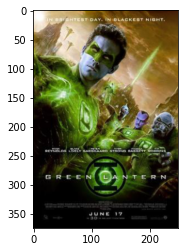

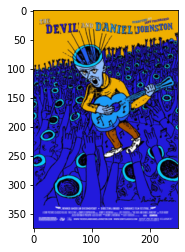

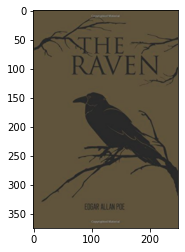

In [49]:
# Testing whether the loaders are okay (printing out 3 images)
i= 0
for inputs, labels in val_loader:
    if(i == 1):
        break
    
    for j in range(3):
        plt.imshow(inputs[j].permute(1, 2, 0))
        plt.show()
    
    i += 1

# 2. Classification (for all 6 genres)

Given that our dataset was relatively small, we sought to use Transfer Learning on pre-trained models. We utilized Pytorch for most of the transfer learning, except for the VGG-Face model, which was only available in .h5 to load onto a keras model__ . Descriptions of each of the models and their unique characteristics are given below.

The models were evaluated on the basis of the following metrics: Accuracy (ratio of correct to total predictions), F1-score (a metrics based on evaluation of true positives and false negatives, which provides more insight than accuracy) [5] and the area under the curve of an ROC Curve (Receiver Operating Characteristic, a plot of the true positive vs. false positive rate, with an area closer to 1 indicating higher performance) [6]. 

We trained on the following models and found the following accuracies:
1. Resnet-18: 40%
2. Resnet-101: 41%
3. VGG-16: 38%
4. AlexNet: 38%
5. VGG-Face: 22%

Overall the models worked quite poorly. We believe this is because many of the posters in the genres are similar (eg. horror and thriller, comedy and romance). Surprisingly, VGG-Face, which had been trained on facial data, performed the worst-- we had expected it to perform well as movies often have large images of people on the front. I assumed this is either because of a corruption in the download of the weights or because the movie poster images were highly stylized and too different from images of faces in the model's training sets. The highest rated models were Resnet-18 and Resnet-101. The results are summarized in the plots for the statistics (Accuracy, F1-score, ROC Area under the curve).

### Defined Pytorch training functions

In [7]:
from torch import nn, optim
import time
import copy
from torchvision.models import resnet18, vgg16, resnet101, alexnet
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score

In [8]:
# I added this method-- large portions of the code are utilized from Pytorch tutorial for transfer learning:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=30):
    start_time = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch= 0

    for epoch in range(num_epochs):
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            total_loss = 0.0
            total_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # putting inputs and labels onto cuda or cpu
                labels = labels.to(device)
                
                model = model.to(device)
                #inputs, labels = inputs.cuda(), labels.cuda()

                optimizer.zero_grad() # zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print("outputs: ", outputs)
                    #print("labels: ", labels)
                    loss = criterion(outputs, labels)
                    #loss = criterion(outputs, labels.unsqueeze(1).float())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                total_loss += loss.item() * inputs.size(0) # statistics
                total_corrects += torch.sum(preds == labels.data)

            epoch_loss = total_loss / dataset_sizes[phase]
            epoch_acc = total_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                best_epoch= epoch

        time_epoch = time.time() - start_epoch
        print("Time for epoch: ", time_epoch)
        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model)
    
    return model, best_epoch, best_acc

In [9]:
def test(model, test_loader):
        
    model.eval()
    
    correct = 0 
    total = 0 
    
    y_truth= []
    y_pred= []
    y_prob= np.empty((0, num_classes))
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            
            inputs = inputs.to(device) # putting inputs and labels onto cuda or cpu
            labels = labels.to(device)
            model= model.to(device)
            
            outputs = model(inputs)
            
            _, predicted= torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
            y_prob_tmp = outputs.cpu().clone()
            row_sums = torch.sum(y_prob_tmp, 1)
            row_sums= row_sums.unsqueeze(1)
            y_prob_tmp = torch.div(y_prob_tmp , row_sums) # https://stackoverflow.com/questions/60026029/roc-curve-and-auc-for-a-multiclass-and-multilabel-problem-valueerror-target-sc
            
            y_truth.append(list(labels.cpu().numpy()))
            y_pred.append(list(predicted.cpu().numpy()))
            #print("y_prob_tmp.cpu().numpy(): ", y_prob_tmp.cpu().numpy())

            #print("y_prob shape: ", y_prob.shape)
            #print("y_prob_tmp.cpu().numpy(): ", y_prob_tmp.cpu().numpy().shape)
            y_prob= np.concatenate((y_prob, y_prob_tmp.cpu().numpy() ), axis=0)
    
    # Formatting lists
    y_truth = [item for sublist in y_truth for item in sublist]
    y_pred = [item for sublist in y_pred for item in sublist]
    
    # Statistics
    acc= (100 * correct / total)
    c_m= confusion_matrix(y_truth, y_pred)
    f1= f1_score(y_truth, y_pred, average='micro')
    
    y_truth_one_hot= np.zeros((len(y_truth), max(y_truth)+1))
    y_truth_one_hot[np.arange(len(y_truth)),y_truth] = 1
    roc_auc= roc_auc_score(y_truth_one_hot, y_prob, multi_class='ovr')
    
    print("Accuracy on test set: %d %%" % acc)
    print("Confusion matrix: ", c_m)
    print("F1 score: ", f1)
    print("ROC AUC: ", roc_auc)
    
    return acc, c_m, f1, roc_auc

In [10]:
def save_chkpt(model, epoch, acc, model_name):
    state = {'model_state_dict': model.state_dict(),
             'epoch': epoch,
             'acc': acc, }
    torch.save(state, 'checkpoint_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar')
    print("checkpoint saved at epoch", epoch)
    return


def load_chkpt(model, chkpt_path):
    checkpoint = torch.load(chkpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    acc = checkpoint['acc']
    print("epoch, acc:", epoch, acc)
    return model, epoch, acc

## a. Resnet-18

Resnet-18 [7] is a convolutional neural network that is 18 layers deep, and was trained on over a million images from ImageNet. Resnet differs from other networks in that it fits residual mapping (of H(x)-x), or the residual between the true and predicted value. I believed it would be a useful place to start as it is trained on ImageNet [8], a huge image database consisting of common images of objects and animals, and many movie posters contain objects in the frame.

The accuracy came out to around 40%.

<img src="embedded_imgs/resnet18.png">

In [50]:
# Parameters: Layers=FROZEN, num_class=6, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet18(pretrained=True)
model_name= 'resnet18'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.7903 Acc: 0.1752
val Loss: 1.7829 Acc: 0.1932
Time for epoch:  116.74424195289612

Epoch 2/15
----------
train Loss: 1.7751 Acc: 0.2256
val Loss: 1.7665 Acc: 0.2515
Time for epoch:  118.0801956653595

Epoch 3/15
----------
train Loss: 1.7537 Acc: 0.2576
val Loss: 1.7484 Acc: 0.2696
Time for epoch:  118.77349853515625

Epoch 4/15
----------
train Loss: 1.7339 Acc: 0.2733
val Loss: 1.7171 Acc: 0.2817
Time for epoch:  117.90064883232117

Epoch 5/15
----------
train Loss: 1.7047 Acc: 0.2934
val Loss: 1.6697 Acc: 0.3441
Time for epoch:  118.02872252464294

Epoch 6/15
----------
train Loss: 1.6835 Acc: 0.3193
val Loss: 1.6461 Acc: 0.3561
Time for epoch:  118.25564551353455

Epoch 7/15
----------
train Loss: 1.6511 Acc: 0.3389
val Loss: 1.6188 Acc: 0.3682
Time for epoch:  117.48300385475159

Epoch 8/15
----------
train Loss: 1.6368 Acc: 0.3473
val Loss: 1.5929 Acc: 0.3763
Time for epoch:  116.74382328987122

Epoch 9/15
----------
train Loss: 1.6093 Acc: 0.3

In [23]:
# On the test set
chkpt_path= 'checkpoint'+'_resnet18'+'_{:.2f}'.format(0.40)+'.pth.tar'
model_resnet18, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet18, c_m_resnet18, f1_resnet18, roc_auc_resnet18= test(model_resnet18, test_loader)

epoch, acc: 12 tensor(0.4044, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 40 %
Confusion matrix:  [[ 0 15  0 32  9  2]
 [ 0 62  1 18 12  1]
 [ 0 18 14 13 16  7]
 [ 0 17  2 48 14  0]
 [ 0 27  3  6 48  3]
 [ 0 15  3 15 19  7]]
F1 score:  0.4004474272930649
ROC AUC:  0.7373022555362313


## b. Resnet-101

In the same paper [7] , He et. al. describe a much deeper residual network, Resnet-101 with 101 layers. They show in the paper that for these residual networks, classification performance increases with depth (as they are able to overcome otherwise existing shortcoming through the use of residual layers, such as overfitting). Resnet-101 has the advantage of being a much deeper network than Resnet-18 and thus in a better position to pick up on the complexities of features in movie posters, is is also shown to perform 3% better than VGG-16. 

The accuracy came out to around 41%.

<img src="embedded_imgs/resnet101.png">

In [12]:
# Parameters: Layers=FROZEN, num_class=6, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet101(pretrained=True)
model_name= 'resnet101'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.7782 Acc: 0.2065
val Loss: 1.7603 Acc: 0.2374
Time for epoch:  333.27400612831116

Epoch 2/15
----------
train Loss: 1.7538 Acc: 0.2606
val Loss: 1.7365 Acc: 0.3380
Time for epoch:  155.3919711112976

Epoch 3/15
----------
train Loss: 1.7326 Acc: 0.2825
val Loss: 1.6960 Acc: 0.3642
Time for epoch:  155.31624126434326

Epoch 4/15
----------
train Loss: 1.7004 Acc: 0.3185
val Loss: 1.6549 Acc: 0.3642
Time for epoch:  154.75143933296204

Epoch 5/15
----------
train Loss: 1.6634 Acc: 0.3344
val Loss: 1.6114 Acc: 0.3662
Time for epoch:  154.51275753974915

Epoch 6/15
----------
train Loss: 1.6399 Acc: 0.3458
val Loss: 1.5709 Acc: 0.3783
Time for epoch:  155.64057517051697

Epoch 7/15
----------
train Loss: 1.6096 Acc: 0.3665
val Loss: 1.5576 Acc: 0.3702
Time for epoch:  154.48796319961548

Epoch 8/15
----------
train Loss: 1.5855 Acc: 0.3677
val Loss: 1.5213 Acc: 0.4145
Time for epoch:  154.22120594978333

Epoch 9/15
----------
train Loss: 1.5617 Acc: 0.3

In [15]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet101, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet101, c_m_resnet101, f1_resnet101, roc_auc_resnet101= test(model_resnet101, test_loader)

epoch, acc: 10 tensor(0.4487, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 41 %
Confusion matrix:  [[ 3 14  1 28  7  5]
 [ 2 64  2 12 13  1]
 [ 0 18 25  9 10  6]
 [ 2 23  4 45  7  0]
 [ 0 25  9  7 41  5]
 [ 0 16  7 12 15  9]]
F1 score:  0.41834451901565994
ROC AUC:  0.7481989758622151


## c. VGG16

VGG-16 [9] pre-dates Resnet by a few months, and was very successful on ImageNet, achieving an accuracy of almost 92.7%. VGG-16 is unique in that it uses multiple smaller kernel filters (3x3) in succession as opposed to larger kernel sizes in networks such as AlexNet. With the focus there being multiple smaller objects and features in a movie poster, I believe the classification will benefit from the use of a very deep network such as VGG-16.

The accuracy came out to around 38%.

<img src="embedded_imgs/vgg16.png">

In [17]:
# Parameters: Layers=FROZEN, num_class=6, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = vgg16(pretrained=True)
model_name= 'vgg16'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = 25088 #model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.classifier = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.7532 Acc: 0.2430
val Loss: 1.6906 Acc: 0.3400
Time for epoch:  148.77557396888733

Epoch 2/15
----------
train Loss: 1.6812 Acc: 0.3230
val Loss: 1.6634 Acc: 0.3400
Time for epoch:  149.63647174835205

Epoch 3/15
----------
train Loss: 1.6194 Acc: 0.3583
val Loss: 1.5870 Acc: 0.3742
Time for epoch:  150.47563195228577

Epoch 4/15
----------
train Loss: 1.5835 Acc: 0.3719
val Loss: 1.5447 Acc: 0.3903
Time for epoch:  149.69864773750305

Epoch 5/15
----------
train Loss: 1.5501 Acc: 0.3901
val Loss: 1.5359 Acc: 0.4004
Time for epoch:  148.77210354804993

Epoch 6/15
----------
train Loss: 1.5146 Acc: 0.4112
val Loss: 1.5180 Acc: 0.3924
Time for epoch:  149.1770761013031

Epoch 7/15
----------
train Loss: 1.4906 Acc: 0.4229
val Loss: 1.5031 Acc: 0.4185
Time for epoch:  149.6053867340088

Epoch 8/15
----------
train Loss: 1.4627 Acc: 0.4316
val Loss: 1.5054 Acc: 0.3803
Time for epoch:  149.22425055503845

Epoch 9/15
----------
train Loss: 1.4319 Acc: 0.45

In [18]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_vgg16, epoch, acc= load_chkpt(model, chkpt_path)
acc_vgg16, c_m_vgg16, f1_vgg16, roc_auc_vgg16= test(model_vgg16, test_loader)

epoch, acc: 6 tensor(0.4185, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 38 %
Confusion matrix:  [[15 16  2 18  6  1]
 [ 3 61  4 16 10  0]
 [ 3 17 15 14 18  1]
 [ 0 25  2 35 18  1]
 [ 4 29  2  4 46  2]
 [ 4  9  3 15 26  2]]
F1 score:  0.38926174496644295
ROC AUC:  0.7084323052708478


## d. AlexNet

AlexNet [10] is also trained on ImageNet and is somewhat older than the previous networks, but still highly influential, using techniques that were less common at the time, such as ReLU and training on multiple GPUs. I didn't expect the classification to perform as well with AlexNet, since it is not as deep, but I wanted to try it out.


The accuracy also came out to around 38%.

<img src="embedded_imgs/alexnet.png">

In [19]:
# Parameters: Layers=FROZEN, num_class=2, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = alexnet(pretrained=True)
model_name= 'alexnet'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = 9216 #model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.classifier = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.7443 Acc: 0.2539
val Loss: 1.7057 Acc: 0.2616
Time for epoch:  110.3005805015564

Epoch 2/15
----------
train Loss: 1.6794 Acc: 0.3165
val Loss: 1.6242 Acc: 0.3521
Time for epoch:  110.34514117240906

Epoch 3/15
----------
train Loss: 1.6264 Acc: 0.3458
val Loss: 1.5957 Acc: 0.3541
Time for epoch:  110.22230005264282

Epoch 4/15
----------
train Loss: 1.5866 Acc: 0.3665
val Loss: 1.5720 Acc: 0.3702
Time for epoch:  110.32464408874512

Epoch 5/15
----------
train Loss: 1.5773 Acc: 0.3719
val Loss: 1.6356 Acc: 0.3421
Time for epoch:  111.44993019104004

Epoch 6/15
----------
train Loss: 1.5532 Acc: 0.3868
val Loss: 1.5681 Acc: 0.3863
Time for epoch:  110.60822081565857

Epoch 7/15
----------
train Loss: 1.5356 Acc: 0.3893
val Loss: 1.5740 Acc: 0.3541
Time for epoch:  110.20865416526794

Epoch 8/15
----------
train Loss: 1.5361 Acc: 0.3988
val Loss: 1.5434 Acc: 0.3742
Time for epoch:  109.960768699646

Epoch 9/15
----------
train Loss: 1.5113 Acc: 0.410

In [51]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(0.41)+'.pth.tar'
model_alexnet, epoch, acc= load_chkpt(model, chkpt_path)
acc_alexnet, c_m_alexnet, f1_alexnet, roc_auc_alexnet= test(model_alexnet, test_loader)

epoch, acc: 8 tensor(0.4125, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 38 %
Confusion matrix:  [[14 14  3 12  8  7]
 [ 0 63  6 14  4  7]
 [ 3 21 16  8 11  9]
 [ 1 24  6 32  9  9]
 [ 4 24  6  6 35 12]
 [ 5 11  6  7 16 14]]
F1 score:  0.38926174496644295
ROC AUC:  0.7143089279300437


## e. VGG-FACE

After running on AlexNet, I realized that part of the reason why the models may be performing poorly is because they are trained on ImageNet, which though it may be a good starting point, primarily contains images of objects instead of people. Therefore, I sought out pre-trained models trained on faces to perhaps improve performance, and looked in detail on ModelZoo.com. I came across some promising projects, such as Facebook's Detectron [11] for identifying and localizing people within an image, but for which the model was in an outdated format. However, through projects on the site, I came across VGG-FACE [12], a VGG-16 like network (13-layers) trained primarily on Facial Data (Labeled Faces in the Wild [13] and the YouTube Faces [14]).

The Pytorch file was corrupted so I utilized Keras for this particular model, by downloading the .h5 file and loading in the weights. Therefore were also memory issues with training on a GPU, so I sought to the crop images to a size (150,100) and change the input size of the model.

The accuracy came out to around 22%.

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# Tensorflow version == 2.0.0

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

In [7]:
# Freezing layers
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [8]:
def add_top_model(end_model, num_classes):
    top= end_model.output
    top= Dense(1024, activation='relu')(top)
    top= Dense(512, activation='relu')(top)
    top= Dense(num_classes, activation='softmax')(top)
    return top

In [12]:
top_model= add_top_model(model, num_classes)
#before_model= add_before_model(model)
model = Model(inputs= model.input, outputs= top_model)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

#### Creating the keras training set
Note: in order to read in the keras dataset and image generators into the model the images had to be cropped to size 224, 224

In [13]:
# Creating list of X,y_train and test

root_dataset_dir= './6_genre_images/'

img_width= 375
img_height= 250

X_total= []
y_total= []

i= 0
for input_path in glob(os.path.join(root_dataset_dir, "**/*.jpg")):
    
    if(i%50 == 0):
        print(i)
        
    img = cv2.imread(input_path)
    img = cv2.resize(img, (img_height, img_width))
    #img = img[75:175, 20:237]
    img = img[50:274, 13:237]

    X_total.append(img)
    
    genre = os.path.basename(os.path.dirname(input_path))
    target = Genre[genre]
    target_one_hot= np.zeros((num_classes,))
    target_one_hot[target.value]=1
    y_total.append(target_one_hot)
    
    i += 1

print("X_total len: ", len(X_total))
print("y_total len: ", len(y_total))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
X_total len:  4969
y_total len:  4969


X_train:  3975
X_test:  994
224
224


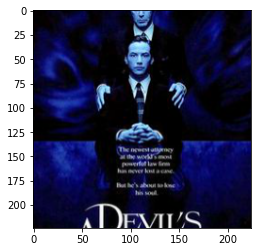

In [28]:
# Example of cropped images

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.20, random_state=42)
print("X_train: ", len(X_train))
print("X_test: ", len(X_test))

X_train= np.array(X_train)
X_test= np.array(X_test)
y_train= np.array(y_train)
y_test= np.array(y_test)

index= 10
print(X_train[index].shape[0])
print(X_train[index].shape[1])
plt.imshow(X_train[index])
plt.show()

In [16]:
# Creating dataset generators

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation transforms
train_datagen= ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)
        #fill_model='nearest')

test_datagen= ImageDataGenerator(
        rescale=1./255)

bsize= 10
train_generator= train_datagen.flow(
        X_train, y_train,
        batch_size=bsize,
        subset= 'training')

validation_generator= train_datagen.flow(
        X_train, y_train,
        batch_size=bsize,
        subset= 'validation')

test_generator= test_datagen.flow(
        X_test, y_test,
        batch_size=bsize)

In [17]:
# Fitting the model

callback= [checkpoint]

# Compiling and running model

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    callbacks=callback,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10
100/100 [==============================] - 125s 1s/step - loss: 1.7742 - accuracy: 0.2052 - val_loss: 1.7570 - val_accuracy: 0.2350

Epoch 00002: val_loss improved from 1.76642 to 1.75702, saving model to vgg_face.h5
Epoch 3/10
100/100 [==============================] - 125s 1s/step - loss: 1.7746 - accuracy: 0.2159 - val_loss: 1.7694 - val_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.75702
Epoch 4/10
100/100 [==============================] - 125s 1s/step - loss: 1.7750 - accuracy: 0.1964 - val_loss: 1.8091 - val_accuracy: 0.1700

Epoch 00004: val_loss did not improve from 1.75702
Epoch 5/10
100/100 [==============================] - 125s 1s/step - loss: 1.7658 - accuracy: 0.2098 - val_loss: 1.7774 - val_accuracy: 0.2200

Epoch 00005: val_loss did not improve from 1.75702
Epoch 6/10
100/100 [==============================] - 125s 1s/step - loss: 1.7703 - accuracy: 0.1943 - val_loss: 1.7926 - val_accuracy: 0.2200

Epoch 00006: val_loss did not improve from 

In [47]:
# Statistics

#y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1) #predicted_classes
y_truth= np.argmax(y_test, axis=1)

corr= 0
total= 0
for i in range(len(y_pred)):
    #print(y_pred[i])
    #print(y_truth[i])
    #print()
    
    if(y_pred[i] == y_truth[i]):
        #print("yo")
        corr += 1
    total += 1

acc= corr/total
#acc= accuracy_score(y_truth, y_pred)
c_m= confusion_matrix(y_truth, y_pred)
f1= f1_score(y_truth, y_pred, average='micro')
    
y_truth_one_hot= np.zeros((len(y_truth), max(y_truth)+1))
y_truth_one_hot[np.arange(len(y_truth)),y_truth] = 1
roc_auc= roc_auc_score(y_truth_one_hot, y_prob, multi_class='ovr')
    
print("Accuracy on test set: %d %%", acc)
print("Confusion matrix: ", c_m)
print("F1 score: ", f1)
print("ROC AUC: ", roc_auc)

acc_vggface= acc
c_m_vggface= c_m
f1_vggface= f1
roc_auc_vggface= roc_auc

Accuracy on test set: %d %% 0.22032193158953722
Confusion matrix:  [[  0 104   0   0   0   0]
 [  0 219   0   0   0   0]
 [  0 156   0   0   0   0]
 [  0 160   0   0   2   0]
 [  0 205   0   0   0   0]
 [  0 147   0   0   1   0]]
F1 score:  0.22032193158953722
ROC AUC:  0.529159128974345


## f. Comparing statistic values between the 5 networks

Expectations were that Resnet-18 (by virtue of being a residual network) and Resnet-101 (by virtue of being an even deeper network) would perform the most well on the model. This was fulfilled, but only marginally, reaching an accuracy of 40% and 41% resp. Going forward, I wanted to see if it was easier to classify between a fewer number of genres, and therefore only choose the top 2 models for training.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [52]:
model_names= ['resnet18', 'resnet101', 'vgg16', 'alexnet', 'vgg-face']
acc= [acc_resnet18, acc_resnet101, acc_vgg16, acc_alexnet, acc_vggface]
acc=[x / 100.0 for x in acc]
cm= [c_m_resnet18, c_m_resnet101, c_m_vgg16, c_m_alexnet, c_m_vggface]
f1= [f1_resnet18, f1_resnet101, f1_vgg16, f1_alexnet, f1_vggface]
roc_auc= [roc_auc_resnet18, roc_auc_resnet101, roc_auc_vgg16, roc_auc_alexnet, roc_auc_vggface] 

In [21]:
# function to plot formatted confusion matrix 
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

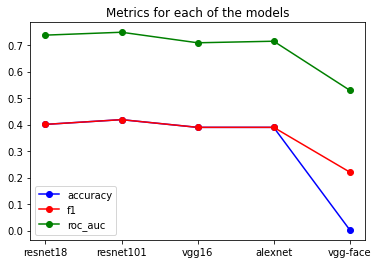

Accuracy values:  [0.4004474272930649, 0.41834451901566, 0.38926174496644295, 0.38926174496644295, 0.002203219315895372]
F1 values:  [0.4004474272930649, 0.41834451901565994, 0.38926174496644295, 0.38926174496644295, 0.22032193158953722]
ROC AUC values:  [0.7373022555362313, 0.7481989758622151, 0.7084323052708478, 0.7143089279300437, 0.529159128974345]


In [54]:
plt.plot(model_names, acc, 'bo-' ,label='accuracy')
plt.plot(model_names, f1, 'ro-' ,label='f1')
plt.plot(model_names, roc_auc, 'go-' ,label='roc_auc')
plt.title("Metrics for each of the models")
plt.legend()
plt.show()
print("Accuracy values: ", acc)
print("F1 values: ", f1)
print("ROC AUC values: ", roc_auc)

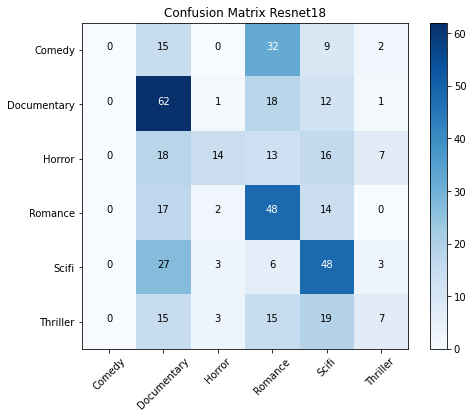

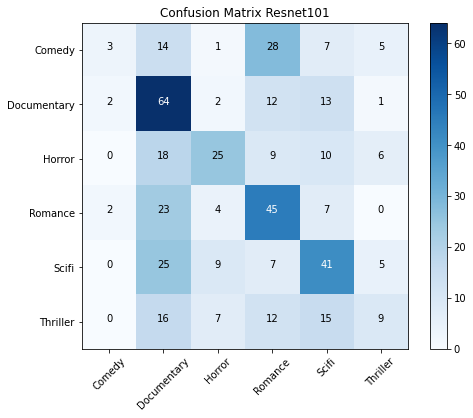

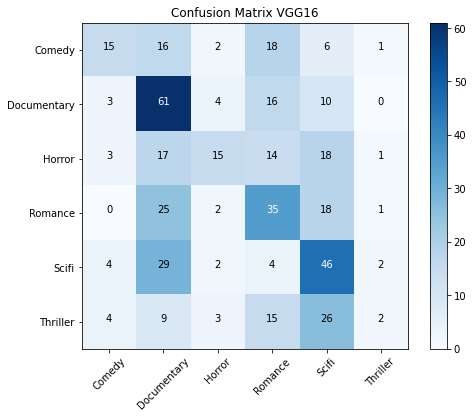

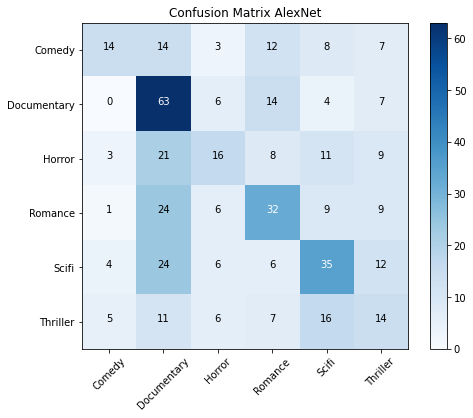

In [58]:
models_list= ['Resnet18', 'Resnet101', 'VGG16', 'AlexNet', 'VGG-FACE']
i= 0

for c_m_ in cm:
    if(i == 4):
        break
    plot_confusion_matrix(cm = c_m_, normalize = False, target_names = genres_list, title = "Confusion Matrix "+models_list[i])
    i += 1

#print(cm[4])
#print(cm)
#print(cm[5])

# 3. Classification (for 4 genres)

We were pondering the poor accuracy of the networks on the 6 genres and realized that part of the reason for the poor performance was the similarity between many of the genres (it is very hard to clearly demarcate between a romance and a comedy for example, or often a sci-fi or thriller). This is seen in the Confusion matrices, where across the networks, the most well-classified genres were the documentary and sci-fi, followed by romance and the thriller. Comedy and horror seemed to perform especially poorly, and one reason could be their proximity to other genres (romance and scifi resp.) in terms of the poster aesthetics, as well the fact that the sizes of these genres were must smaller than the others (due to the removal of duplicates).

Therefore, I sought to try out if these models could perform decently on the 4 better performing genres (documentary, scifi, romance and thriller). I only chose to try out the two most well-performing models-- Resnet-18 and VGG-16.

The accuracies were somewhat better, with Resnet-18 having an accuracy of 55% and Resnet-101 having an accuracy of 59%.

In [86]:
root_dataset_dir= './4_genre_images/'
#genres_list= ['Documentary', 'Romance', 'Scifi', 'Thriller']
genres_list= ['Documentary', 'Horror', 'Romance', 'Scifi']
num_classes= 4

In [87]:
class Genre(Enum):
    """documentary= 0
    romance= 1
    scifi= 2
    thriller= 3"""
    documentary= 0
    horror= 1
    romance= 2
    scifi= 3
    
class MovieDataset(Dataset):
    def __init__(self, dataset_dir=root_dataset_dir, transform=None):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.data = list()
        
        for input_path in glob(os.path.join(self.dataset_dir, "**/*.jpg")): #.png
            genre = os.path.basename(os.path.dirname(input_path))
            
            try:
                target = Genre[genre]
            except Exception:
                print(f"Invalid genre {genre} for input_path {input_path}")
                continue
            
            self.data.append({"input_path": input_path, "target": target.value})
        self.print_statistics()
        
    def print_statistics(self):
        print("MovieDataset statistics:")
        print(f"> Totat datapoints: {len(self.data)}")
    
    def get_target(genre:Genre):
        return genre.value
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index]
        img = cv2.imread(datapoint["input_path"])
        
        if img is None:
            print(datapoint["input_path"])
            
        if self.transform is not None:
            img = self.transform(img)
        return  img, datapoint["target"]

In [88]:
# With dataset Normalization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = MovieDataset(dataset_dir=root_dataset_dir) #, transform=transform) #DELETE!!!!
len_dataset= len(dataset)

Using device: cuda
MovieDataset statistics:
> Totat datapoints: 3671


In [89]:
# Creating train, test and val set

b_size= 10 # batch_size
split= 0.90
tmp_train_set, tmp_val_set= torch.utils.data.random_split(dataset, [round(split*len_dataset), round((1-split)*len_dataset)])
train_set, tmp_test_set= torch.utils.data.random_split(tmp_train_set, [round(split*len(tmp_train_set)), round((1-split)*len(tmp_train_set))])
val_set= copy.deepcopy(tmp_val_set)
test_set= copy.deepcopy(tmp_test_set)

img_width= 375
img_height= 250

transform = {
    'train':
        transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_width, img_height)),
        transforms.RandomAffine(0, scale=(0.8,1.2), shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
    
    'val':
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_width,img_height)),
            transforms.ToTensor() ]) }

train_set.dataset.dataset.transform = transform['train']
val_set.dataset.transform = transform['val']
test_set.dataset.dataset.transform = transform['val']

# Creating Dataset Loaders

train_loader= DataLoader(train_set, batch_size=b_size, shuffle=True, num_workers=0)
val_loader= DataLoader(val_set, batch_size=b_size, shuffle=True, num_workers=0)
test_loader= DataLoader(test_set, batch_size=b_size, shuffle=True, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

{'train': 2974, 'val': 367}


## a. Resnet-18

In [90]:
# Parameters: Layers=FROZEN, num_class=4, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet18(pretrained=True)
model_name= 'resnet18_4'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.3810 Acc: 0.2996
val Loss: 1.3912 Acc: 0.2725
Time for epoch:  96.35787868499756

Epoch 2/15
----------
train Loss: 1.3318 Acc: 0.3749
val Loss: 1.2687 Acc: 0.4360
Time for epoch:  96.88983511924744

Epoch 3/15
----------
train Loss: 1.2894 Acc: 0.4132
val Loss: 1.1480 Acc: 0.5204
Time for epoch:  97.88837146759033

Epoch 4/15
----------
train Loss: 1.2556 Acc: 0.4512
val Loss: 1.1262 Acc: 0.5341
Time for epoch:  97.99015712738037

Epoch 5/15
----------
train Loss: 1.2402 Acc: 0.4644
val Loss: 1.1146 Acc: 0.5477
Time for epoch:  97.58858036994934

Epoch 6/15
----------
train Loss: 1.2340 Acc: 0.4603
val Loss: 1.1122 Acc: 0.5450
Time for epoch:  96.20282578468323

Epoch 7/15
----------
train Loss: 1.2111 Acc: 0.4697
val Loss: 1.1222 Acc: 0.5477
Time for epoch:  96.8812518119812

Epoch 8/15
----------
train Loss: 1.2105 Acc: 0.4781
val Loss: 1.1055 Acc: 0.5559
Time for epoch:  96.11699295043945

Epoch 9/15
----------
train Loss: 1.1961 Acc: 0.4845
val 

epoch, acc: 14 tensor(0.5586, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 55 %
Confusion matrix:  [[68  2 15 18]
 [15 16 11 15]
 [19  2 62 10]
 [22  8 11 36]]
F1 score:  0.5515151515151515
ROC AUC:  0.7766113882691991


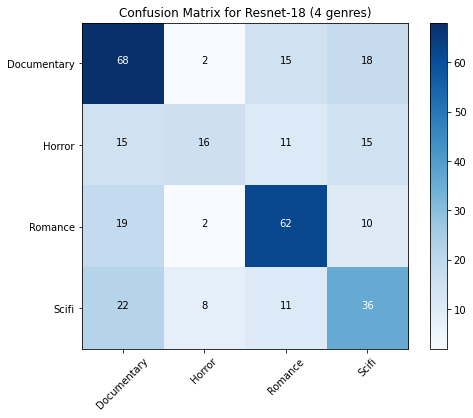

In [91]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet18, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet18_4, c_m_resnet18_4, f1_resnet18_4, roc_auc_resnet18_4= test(model_resnet18, test_loader)
plot_confusion_matrix(cm = c_m_resnet18_4, normalize = False, target_names = genres_list, title = "Confusion Matrix for Resnet-18 (4 genres)")

## b. Resnet-101

In [73]:
# Parameters: Layers=FROZEN, num_class=4, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet101(pretrained=True)
model_name= 'resnet101_4'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 1.3783 Acc: 0.2929
val Loss: 1.3550 Acc: 0.2970
Time for epoch:  120.25286626815796

Epoch 2/15
----------
train Loss: 1.3567 Acc: 0.3312
val Loss: 1.3145 Acc: 0.4114
Time for epoch:  121.53639793395996

Epoch 3/15
----------
train Loss: 1.3203 Acc: 0.3816
val Loss: 1.2584 Acc: 0.4469
Time for epoch:  121.79648017883301

Epoch 4/15
----------
train Loss: 1.2828 Acc: 0.4274
val Loss: 1.2137 Acc: 0.5041
Time for epoch:  122.4267065525055

Epoch 5/15
----------
train Loss: 1.2598 Acc: 0.4408
val Loss: 1.2301 Acc: 0.4033
Time for epoch:  121.44776630401611

Epoch 6/15
----------
train Loss: 1.2288 Acc: 0.4496
val Loss: 1.1375 Acc: 0.5313
Time for epoch:  121.57602596282959

Epoch 7/15
----------
train Loss: 1.2201 Acc: 0.4576
val Loss: 1.1185 Acc: 0.5559
Time for epoch:  121.60022234916687

Epoch 8/15
----------
train Loss: 1.1918 Acc: 0.4866
val Loss: 1.0860 Acc: 0.5477
Time for epoch:  121.74157547950745

Epoch 9/15
----------
train Loss: 1.1791 Acc: 0.4

epoch, acc: 10 tensor(0.5940, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 59 %
Confusion matrix:  [[54  3 11 28]
 [ 5 18  5 20]
 [13  6 58 16]
 [11  6  9 67]]
F1 score:  0.5969696969696969
ROC AUC:  0.8140503237057214


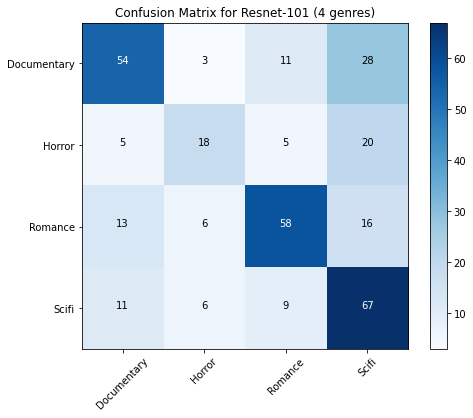

In [75]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet101, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet101_4, c_m_resnet101_4, f1_resnet101_4, roc_auc_resnet101_4= test(model_resnet101, test_loader)
plot_confusion_matrix(cm = c_m_resnet101_4, normalize = False, target_names = genres_list, title = "Confusion Matrix for Resnet-101 (4 genres)")

# 3. Binary classification (for 2 genres)

Given the still sub-par performance on 4 genres, I wanted to see if the models performed well on binary classification. Looking at the confusion matrices from the previous two problems, I think that two directories with clear demarcations in classification are 'romance' and 'horror'.

The accuracy was definitely the highest out of all the tasks, reaching 81% and 86% for Resnet-18 and Resnet-100 resp., with the unfrozen model for Resnet-18 close at 79%. I postulate that this is due to the clear differences in color and figures that frequented the posters from these two genres.

In [12]:
root_dataset_dir= './2_genre_images/'
genres_list= ['Horror', 'Romance']
num_classes= 2

In [13]:
class Genre(Enum):
    horror= 0
    romance= 1
    
class MovieDataset(Dataset):
    def __init__(self, dataset_dir=root_dataset_dir, transform=None):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.data = list()
        
        for input_path in glob(os.path.join(self.dataset_dir, "**/*.jpg")): #.png
            genre = os.path.basename(os.path.dirname(input_path))
            
            try:
                target = Genre[genre]
            except Exception:
                print(f"Invalid genre {genre} for input_path {input_path}")
                continue
            
            self.data.append({"input_path": input_path, "target": target.value})
        self.print_statistics()
        
    def print_statistics(self):
        print("MovieDataset statistics:")
        print(f"> Totat datapoints: {len(self.data)}")
    
    def get_target(genre:Genre):
        return genre.value
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index]
        img = cv2.imread(datapoint["input_path"])
        
        if img is None:
            print(datapoint["input_path"])
        
        if self.transform is not None:
            img = self.transform(img)
        return  img, datapoint["target"]

In [14]:
# With dataset Normalization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = MovieDataset(dataset_dir=root_dataset_dir) #, transform=transform) #DELETE!!!!
len_dataset= len(dataset)

Using device: cuda
MovieDataset statistics:
> Totat datapoints: 1603


In [15]:
# Creating train, test and val set

b_size= 10 # batch_size
split= 0.90
tmp_train_set, tmp_val_set= torch.utils.data.random_split(dataset, [round(split*len_dataset), round((1-split)*len_dataset)])
train_set, tmp_test_set= torch.utils.data.random_split(tmp_train_set, [round(split*len(tmp_train_set)), round((1-split)*len(tmp_train_set))])
val_set= copy.deepcopy(tmp_val_set)
test_set= copy.deepcopy(tmp_test_set)

img_width= 375
img_height= 250

transform = {
    'train':
        transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((img_width, img_height)),
        transforms.RandomAffine(0, scale=(0.8,1.2), shear=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
    
    'val':
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_width,img_height)),
            transforms.ToTensor() ]) }

train_set.dataset.dataset.transform = transform['train']
val_set.dataset.transform = transform['val']
test_set.dataset.dataset.transform = transform['val']

# Creating Dataset Loaders

train_loader= DataLoader(train_set, batch_size=b_size, shuffle=True, num_workers=0)
val_loader= DataLoader(val_set, batch_size=b_size, shuffle=True, num_workers=0)
test_loader= DataLoader(test_set, batch_size=b_size, shuffle=True, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

{'train': 1299, 'val': 160}


## a. Resnet-18

In [81]:
# Parameters: Layers=FROZEN, num_class=2, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet18(pretrained=True)
model_name= 'resnet18_2'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 0.6842 Acc: 0.5604
val Loss: 0.6181 Acc: 0.6562
Time for epoch:  53.18674564361572

Epoch 2/15
----------
train Loss: 0.6372 Acc: 0.6590
val Loss: 0.5462 Acc: 0.7188
Time for epoch:  25.68306875228882

Epoch 3/15
----------
train Loss: 0.6194 Acc: 0.6559
val Loss: 0.4942 Acc: 0.7688
Time for epoch:  26.147521018981934

Epoch 4/15
----------
train Loss: 0.5867 Acc: 0.7013
val Loss: 0.5339 Acc: 0.7438
Time for epoch:  26.060932874679565

Epoch 5/15
----------
train Loss: 0.5801 Acc: 0.6967
val Loss: 0.4671 Acc: 0.7500
Time for epoch:  26.137179851531982

Epoch 6/15
----------
train Loss: 0.5365 Acc: 0.7344
val Loss: 0.4731 Acc: 0.7875
Time for epoch:  25.785330533981323

Epoch 7/15
----------
train Loss: 0.5567 Acc: 0.7244
val Loss: 0.5063 Acc: 0.7375
Time for epoch:  25.649637460708618

Epoch 8/15
----------
train Loss: 0.5539 Acc: 0.7306
val Loss: 0.4501 Acc: 0.7875
Time for epoch:  25.68743062019348

Epoch 9/15
----------
train Loss: 0.5295 Acc: 0.739

epoch, acc: 13 tensor(0.8063, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 80 %
Confusion matrix:  [[54 13]
 [15 62]]
F1 score:  0.8055555555555556
ROC AUC:  0.8646055437100213


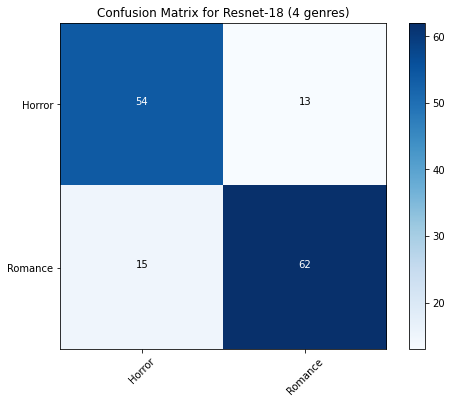

In [82]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet18, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet18_2, c_m_resnet18_2, f1_resnet18_2, roc_auc_resnet18_2= test(model_resnet18, test_loader)
plot_confusion_matrix(cm = c_m_resnet18_2, normalize = False, target_names = genres_list, title = "Confusion Matrix for Resnet-18 (2 genres)")

In [19]:
# Parameters: Layers=!UNFROZEN!, num_class=2, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet18(pretrained=True)
model_name= 'resnet18_2_unfrozen'

# freezing layers
#for param in model.parameters():
#    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 0.6515 Acc: 0.5951
val Loss: 0.5160 Acc: 0.7500
Time for epoch:  29.612331867218018

Epoch 2/15
----------
train Loss: 0.5197 Acc: 0.7552
val Loss: 0.5204 Acc: 0.7500
Time for epoch:  29.37711000442505

Epoch 3/15
----------
train Loss: 0.4814 Acc: 0.7806
val Loss: 0.4556 Acc: 0.7625
Time for epoch:  29.616936922073364

Epoch 4/15
----------
train Loss: 0.4545 Acc: 0.7914
val Loss: 0.4551 Acc: 0.7812
Time for epoch:  29.589962244033813

Epoch 5/15
----------
train Loss: 0.4344 Acc: 0.7991
val Loss: 0.4248 Acc: 0.8063
Time for epoch:  29.451849699020386

Epoch 6/15
----------
train Loss: 0.4285 Acc: 0.8022
val Loss: 0.4461 Acc: 0.7938
Time for epoch:  29.58318543434143

Epoch 7/15
----------
train Loss: 0.3992 Acc: 0.8268
val Loss: 0.4210 Acc: 0.8125
Time for epoch:  29.491066455841064

Epoch 8/15
----------
train Loss: 0.3692 Acc: 0.8399
val Loss: 0.4606 Acc: 0.8000
Time for epoch:  29.453344583511353

Epoch 9/15
----------
train Loss: 0.3658 Acc: 0.85

epoch, acc: 12 tensor(0.8250, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 79 %
Confusion matrix:  [[52 10]
 [20 62]]
F1 score:  0.7916666666666666
ROC AUC:  0.8124508261211645


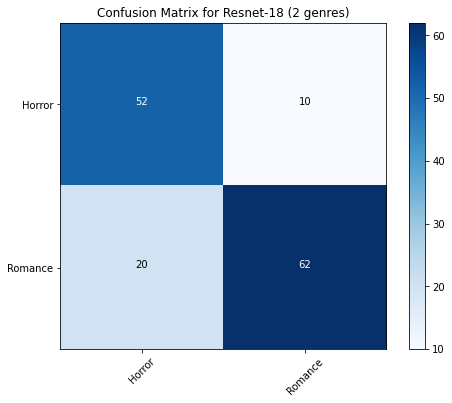

In [22]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet18, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet18_2, c_m_resnet18_2, f1_resnet18_2, roc_auc_resnet18_2= test(model_resnet18, test_loader)
plot_confusion_matrix(cm = c_m_resnet18_2, normalize = False, target_names = genres_list, title = "Confusion Matrix for Resnet-18 (2 genres)")

## b. Resnet-101

In [83]:
# Parameters: Layers=FROZEN, num_class=2, top_model=3 FC, optimizer=SGD, lr=1e-3, batch_size=5, num_epochs=5

model = resnet101(pretrained=True)
model_name= 'resnet101_4'

# freezing layers
for param in model.parameters():
    param.requires_grad = False

# replacing last fc layer
num_ftrs = model.fc.in_features

top_model= nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes), # change to 2 or 1
    nn.ReLU(inplace=True))

model.fc = top_model
#print("model: ", model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

model, epoch, acc = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=15)

# saving model
save_chkpt(model, epoch, acc, model_name)

Epoch 1/15
----------
train Loss: 0.6882 Acc: 0.5296
val Loss: 0.6738 Acc: 0.5687
Time for epoch:  37.33683395385742

Epoch 2/15
----------
train Loss: 0.6413 Acc: 0.6297
val Loss: 0.5808 Acc: 0.7812
Time for epoch:  37.15250253677368

Epoch 4/15
----------
train Loss: 0.5965 Acc: 0.7121
val Loss: 0.5017 Acc: 0.7625
Time for epoch:  37.01133370399475

Epoch 5/15
----------
train Loss: 0.5620 Acc: 0.7236
val Loss: 0.4910 Acc: 0.7812
Time for epoch:  37.05054521560669

Epoch 6/15
----------
train Loss: 0.5529 Acc: 0.7152
val Loss: 0.5207 Acc: 0.7125
Time for epoch:  36.92866897583008

Epoch 7/15
----------
train Loss: 0.5378 Acc: 0.7360
val Loss: 0.4241 Acc: 0.8125
Time for epoch:  37.04014182090759

Epoch 8/15
----------
train Loss: 0.5367 Acc: 0.7360
val Loss: 0.4719 Acc: 0.7625
Time for epoch:  36.884987354278564

Epoch 9/15
----------
train Loss: 0.5223 Acc: 0.7352
val Loss: 0.4366 Acc: 0.7688
Time for epoch:  36.74300718307495

Epoch 10/15
----------
train Loss: 0.5091 Acc: 0.7521
v

epoch, acc: 11 tensor(0.8375, device='cuda:0', dtype=torch.float64)
Accuracy on test set: 81 %
Confusion matrix:  [[53 14]
 [12 65]]
F1 score:  0.8194444444444444
ROC AUC:  0.8913549137429735


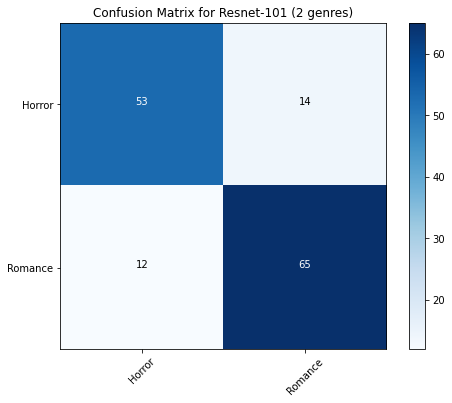

In [85]:
# On the test set
chkpt_path= 'checkpoint'+'_'+model_name+'_{:.2f}'.format(acc)+'.pth.tar'
model_resnet101, epoch, acc= load_chkpt(model, chkpt_path)
acc_resnet101_2, c_m_resnet101_2, f1_resnet101_2, roc_auc_resnet101_2= test(model_resnet101, test_loader)
plot_confusion_matrix(cm = c_m_resnet101_2, normalize = False, target_names = genres_list, title = "Confusion Matrix for Resnet-101 (2 genres)")

# 4. Image Captioning

### Background
As mentioned in the Introduction, one more task we aimed to attempt on this Movie Genre dataset was to attempt image captioning. This would be helpful to increase accessibility for viewers, as captions for movie posters (or other visual artistic media) can be automatically generated without human intervention and labour, and the captions can be streamlined into other means (eg. audio, Braille, etc.) that are more accessible to the visually impaired. 

We learned about LSTMs in the Natural Language Course I enrolled in last semester, and so I applied this technique to this dataset. My partner Jetasri is working on a more sophisticated kind of Image captioning (involving fine-tuning the model described below and ImageBERT). However, I attempted to train the bidirectional LSTM on an entirely different dataset (a limited form of the 'flickr8k data set' [15], containing 6000 training images with captions. I also utilized large amounts of the final homework assigment for the Natural Language Processing course, some of which was given to me (eg. the definition of the model, the dataset, and the functions for reading the dataset) and the rest of which was written by me (the function read_image_descriptions for reading in the captions, the generation of the word_to_id and id_to_word dictionaries, and the image decoders (Greedy and Beam)). I have submitted the notebook for the training of the model separately, as I had easy access to data on the Google drive to colab (which was not possible through GCP).

### Overview
The raw images of the dataset (training, development/validation, test) are stored in a directory, as is a text file consisting of their image paths, so that the raw images can be read in as needed. The images are encoded using an adjusted version of the InceptionV3 network [16] (trained on ImageNet), which outputs a tensor "encoding" the image data (the final layer is changed from an output of 1000 to 2048), which is easier for a joint model to predict on.
The captions are then read in from a different text file, with 5 captions per image and each caption consisting of tokens (basic units like words), and are then cleaned up to include <'START'> and <'END'> tokens. Each of these tokens are then mapped to an index (to convert string into numerical data for training purposes) and can be easily converted using dictionaries (in one-hot form). 
The input data now consists of the raw image and the associated list of captions, which are jointly fed into the model. The architchture of the model is displayed below. It is a bidirectional LSTM-- an LSTM is a model that essentially maps a word in the input sequence to the next word, thus creating a chain. The LSTM is bidirectional because it reads in/encodes the input string both ways, which improves its robustness.

<img src="embedded_imgs/lstm.PNG">

Once the model is trained, it outputs an id for one of the words, when can be converted to a word using the corresponding dictionary. We can use two different decoder algorithms to predict the sequence. The greedy decoder will simply output the highest probability word each time, which can lead to some finnicky outputs. The beam decoder, which keeps track of the n most likely words, which removes some of the flukishness of the greedy decoder.

### Results
Given that the model was trained on an entirely different dataset and with relatively simple images and captions (dog chasing ball, child jumping off rock, etc.), the model performed decently. It is able to identify color ("black", "blue", "red") and some figures ("man", "woman", etc.). However, given that movie posters are mostly images of people, and the Flickr dataset consisted of only a limited number of images with people (and more images of dogs, rocks, etc.), the predicted captions were quite limited in vocabulary. E.g. anytime there was a person and a black background on the movie poster, the caption would usually contain the phrase "man wearing a black jacket". The beam decoder did also perform somewhat better than the greedy decoder, outputting more relevant phrases such as ['<START>', 'a', 'man', 'and', 'a', 'woman', 'are', 'talking', 'on', 'a', 'bench', '.', '<END>'] vs. ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'white', 'jacket', 'is', 'talking', 'to', 'a', 'man', 'in', 'a', 'white', 'jacket', '.', '<END>'] for the film 'Letters to Juliet'.

In [101]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation

from numpy import newaxis
from keras import Sequential, Model
import PIL

In [73]:
import numpy as np

In [77]:
# Creating test set txt file
import random

IMG_PATH = ""
root_dataset_dir= './6_genre_images/'
movie_title_paths= []
for input_path in glob(os.path.join(root_dataset_dir, "**/*.jpg")):
    movie_title_paths.append(input_path)    
random.shuffle(movie_title_paths)

with open('testImages.txt', 'w') as f:
    for item in movie_title_paths:
        f.write("%s\n" % item)

In [78]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                      

In [79]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]

test_list= load_image_list('testImages.txt')

In [92]:
img_model = InceptionV3(weights='imagenet')
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output)

def img_generator(img_list):
    i= 0
    for each_img in img_list:
        image = get_image(each_img)
        
        if(image.shape != (299,299, 3)):
            #print(image.shape)
            i += 1
            continue
        
        image= image[newaxis, :, :, :]
        yield image

In [115]:
# Loading in word2id and id2word conversions
import pickle
with open('image_captioning/word2id.pickle', 'rb') as f:
    word_to_id = pickle.load(f)
with open('image_captioning/id2word.pickle', 'rb') as f:
    id_to_word = pickle.load(f)

In [94]:
# encoding test images to be run on the trained model

enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

4969/4969 [==============================] - 147s 30ms/step


In [108]:
# Loading in NLP model

MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300
vocab_size= 7707

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
nlp_model = Model(inputs=[img_input,text_input],outputs=pred)
nlp_model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

nlp_model.summary()

nlp_model.load_weights("image_captioning/model.h5")

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 300)          614700      input_23[0][0]                   
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 40, 300)      0           dense_11[0][0]                   
___________________________________________________________________________________________

In [109]:
def img_decoder(enc_image, nlp_model): #image_decoder
  
  i= 0
  sequence= ['<START>']

  while(i < MAX_LEN):

    inp_array= np.zeros(MAX_LEN)
    for x in range(len(sequence)):
      each_word= sequence[x]
      inp_array[x]= word_to_id[each_word]

    inp_array_batch= inp_array[newaxis, :]
    enc_image_batch= enc_image[newaxis, :]
    inp= [enc_image_batch, inp_array_batch]

    out_array= nlp_model.predict(inp)
    index= np.argmax(out_array)
    outp= id_to_word[index]

    sequence.append(outp)

    if(outp == '<END>'):
      break

  i += 1

  return sequence

In [120]:
def beam_decoder(n, image_enc, nlp_model):

  img_encoding= image_enc #enc_dev[dev_list.index(image_enc)]
   
  i= 0

  list_of_sequences= [ (1, ['<START>'], False)] # the last is a flag about whether the end has been reached
  new_options= []

  while(i < MAX_LEN):
    #print(list_of_sequences)

    new_options.clear()

    for sequence_tuple in list_of_sequences:
      probs_sequence= sequence_tuple[0]
      sequence= sequence_tuple[1]
      has_sentence_ended= sequence_tuple[2]

      if(has_sentence_ended):
        new_options.append( tuple( (probs_sequence , sequence, True) ) )
        continue

      else:

        # creating the text encoding part of input
        inp_array= np.zeros(MAX_LEN)
        for x in range(len(sequence)):
          each_word= sequence[x]
          inp_array[x]= word_to_id[each_word]

        # creating the complete input (with image encoding too)
        inp_array_batch= inp_array[newaxis, :]
        enc_image_batch= img_encoding[newaxis, :]
        inp= [enc_image_batch, inp_array_batch]

        # generating output array and determining max index/return word
        out_array= nlp_model.predict(inp)[0]
        list_of_output_tuples= []

        for j in range(len(out_array)): # determining original indexes of sorted values
          list_of_output_tuples.append(tuple( (out_array[j], j) ))

        list_of_output_tuples.sort(reverse=True)
        list_of_output_tuples= list_of_output_tuples[:n]

        # creating successors and probabilities
        n_successors= [ id_to_word[each[1]] for each in list_of_output_tuples[:n] ]
        n_probs= [ each[0] for each in list_of_output_tuples[:n] ]

        # creating new options for rest of sequence
        for k in range(len(n_successors)):
          tmp_sequence= sequence + [n_successors[k]]

          if(n_successors[k] == '<END>'):
            new_options.append( tuple( ( (n_probs[k]*probs_sequence) , tmp_sequence, True) ) )
          else:
            new_options.append( tuple( ( (n_probs[k]*probs_sequence) , tmp_sequence, False) ) )

    # Pruning new options to reduce it down to size n
    new_options.sort(reverse=True)
    new_options= new_options[:n]

    # Assigning new sequence list to these options
    list_of_sequences= new_options.copy()

    i += 1

  # MOST prob sequence
  most_prob_sequence= max(list_of_sequences)[1]
  
  return most_prob_sequence

img_name:  ./6_genre_images/comedy/Fear_and_Loathing_in_Las_Vegas_1998.jpg


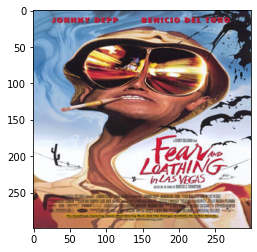

Greedy:  ['<START>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'being', 'dog', 'on', 'a', 'red', 'board', '.', '<END>']
Beam, n=3:  ['<START>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'glasses', 'is', 'being', 'dog', '.', '<END>']
Beam, n=5:  ['<START>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'man', 'in', 'a', 'blue', 'jacket', '.', '<END>']


In [123]:
# Predicting captions for some of the images

index= 0
img_name= test_list[index]
print("img_name: ", img_name)
plt.imshow(get_image(img_name))
plt.show()

#1) Greedy decoder
print("Greedy: ", img_decoder(enc_test[index], nlp_model))

#2) Beam decoder, n=3
print("Beam, n=3: ", beam_decoder(3, enc_test[index], nlp_model))

#3) Beam decoder, n=5
print("Beam, n=5: ",beam_decoder(5, enc_test[index], nlp_model))

img_name:  thriller/Killing_Them_Softly_2012.jpg


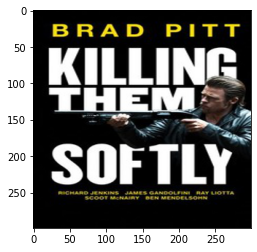

Greedy:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'black', 'jacket', 'is', 'standing', 'on', 'a', 'large', 'rock', '.', '<END>']
Beam, n=3:  ['<START>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'sunglasses', 'sits', 'in', 'the', 'water', '.', '<END>']
Beam, n=5:  ['<START>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'sunglasses', 'sits', 'in', 'the', 'water', '.', '<END>']


In [129]:
# Predicting captions for some of the images

index= 557
img_name= test_list[index]
print("img_name: ", img_name[17:])
plt.imshow(get_image(img_name))
plt.show()

#1) Greedy decoder
print("Greedy: ", img_decoder(enc_test[index], nlp_model))

#2) Beam decoder, n=3
print("Beam, n=3: ", beam_decoder(3, enc_test[index], nlp_model))

#3) Beam decoder, n=5
print("Beam, n=5: ",beam_decoder(5, enc_test[index], nlp_model))

img_name:  ./6_genre_images/romance/The_Nanny_Diaries_2007.jpg


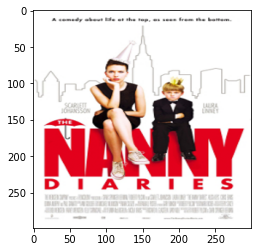

Greedy:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'black', 'jacket', 'is', 'standing', 'in', 'a', 'room', '.', '<END>']
Beam, n=3:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'black', 'shorts', 'is', 'standing', 'in', 'a', 'room', '.', '<END>']
Beam, n=5:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'black', 'jacket', 'sits', 'in', 'the', 'water', '.', '<END>']


In [127]:
# Predicting captions for some of the images

index= 1030
img_name= test_list[index]
print("img_name: ", img_name[17:])
plt.imshow(get_image(img_name))
plt.show()

#1) Greedy decoder
print("Greedy: ", img_decoder(enc_test[index], nlp_model))

#2) Beam decoder, n=3
print("Beam, n=3: ", beam_decoder(3, enc_test[index], nlp_model))

#3) Beam decoder, n=5
print("Beam, n=5: ",beam_decoder(5, enc_test[index], nlp_model))

img_name:  documentary/Van_Gogh__Painted_with_Words_2010.jpg


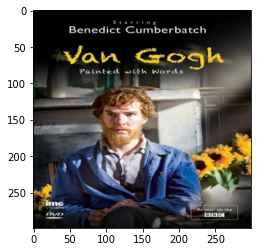

Greedy:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'black', 'jacket', 'is', 'talking', 'to', 'a', 'man', 'in', 'a', 'white', 'jacket', '.', '<END>']
Beam, n=3:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'black', 'jacket', 'is', 'talking', 'to', 'a', 'man', 'in', 'black', '.', '<END>']
Beam, n=5:  ['<START>', 'a', 'group', 'of', 'people', 'sit', 'in', 'front', 'of', 'a', 'building', '.', '<END>']


In [136]:
# Predicting captions for some of the images

index= random. randint(1,4969)
img_name= test_list[index]
print("img_name: ", img_name[17:])
plt.imshow(get_image(img_name))
plt.show()

#1) Greedy decoder
print("Greedy: ", img_decoder(enc_test[index], nlp_model))

#2) Beam decoder, n=3
print("Beam, n=3: ", beam_decoder(3, enc_test[index], nlp_model))

#3) Beam decoder, n=5
print("Beam, n=5: ",beam_decoder(5, enc_test[index], nlp_model))

img_name:  romance/Letters_to_Juliet_2010.jpg


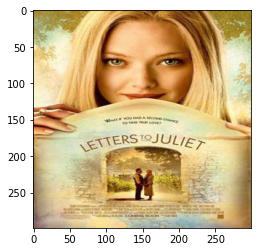

Greedy:  ['<START>', 'a', 'man', 'in', 'a', 'black', 'jacket', 'and', 'white', 'jacket', 'is', 'talking', 'to', 'a', 'man', 'in', 'a', 'white', 'jacket', '.', '<END>']
Beam, n=3:  ['<START>', 'a', 'man', 'and', 'a', 'woman', 'are', 'talking', 'on', 'a', 'bench', '.', '<END>']
Beam, n=5:  ['<START>', 'a', 'man', 'and', 'a', 'woman', 'are', 'talking', 'on', 'a', 'bench', '.', '<END>']


In [143]:
# Predicting captions for some of the images

index= random. randint(1,4969)
img_name= test_list[index]
print("img_name: ", img_name[17:])
plt.imshow(get_image(img_name))
plt.show()

#1) Greedy decoder
print("Greedy: ", img_decoder(enc_test[index], nlp_model))

#2) Beam decoder, n=3
print("Beam, n=3: ", beam_decoder(3, enc_test[index], nlp_model))

#3) Beam decoder, n=5
print("Beam, n=5: ",beam_decoder(5, enc_test[index], nlp_model))

# Discussion

The performance on the 6-genre dataset was quite poor, and is most likely due to the fact that there were simply too many genres with overlaps. Many genres were similar in the composition of the posters (eg. scifi and horror had dark color schemes). That is why the deep learning classification was much more successful on 2 genres. Moreover, even though duplicates were removed, some remaining genre sets (eg. comedy) were too small (~600 images). The pre-trained networks were also perhaps not well suited to the data (evidenced by how the accuracy improved when unfrozen while training). While I had assumed the VGG-FACE model might have performed better for thie reason, it performed the worse out of all the models, which may be due to corruption in the weights of the model file, or that it should have been trained for longer or with different parameters, or that these highly stylized, aesthetic movie posters are very different from the kind of ordinary facial image datasets the VGG-FACE model has been trained on.

In terms of next steps, I think a good place to start would be with multi-label classification, such that the network outputs would be a tuple of multiple labels, helping address the issue of overlapping genres. I would also aim to use a more specialized model, either trained on facial data or on images of people as opposed to objects, and ensure that it is loaded correctly. In addition, datasets trained on more complex images, with multiple features and colors, might also be helpful. With regards to image classification, it would be pertinent to tailor the classification to the current movie genre dataset, lifting captions from the IMDb tags or movie synopses perhaps-- either training on this movie poster dataset entirely with the bidrectional LSTM or fine-tne the current Flikr-8k model on this set to improve performance.

# Bibliography
[1] http://data.uis.unesco.org/?ReportId=5538

[2] A multimodal approach for multi-label movie genre classification. https://arxiv.org/abs/2006.00654

[3] https://www.selenium.dev/

[4] https://stackoverflow.com/questions/37184173/how-to-scrape-the-images-from-the-website

[5] https://arxiv.org/pdf/1402.1892.pdf, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

[6] https://www.sciencedirect.com/science/article/abs/pii/S0031320396001422, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

[7] Deep Residual Learning for Image Recognition https://arxiv.org/pdf/1512.03385.pdf

[8] O. Russakovsky, J. Deng, H. Su, J. Krause, S. Satheesh, S. Ma,
Z. Huang, A. Karpathy, A. Khosla, M. Bernstein, et al. Imagenet
large scale visual recognition challenge. arXiv:1409.0575, 2014.

[9] https://arxiv.org/pdf/1409.1556.pdf

[10] https://arxiv.org/pdf/1404.5997.pdf

[11] https://github.com/facebookresearch/Detectron/blob/master/MODEL_ZOO.md

[12] https://www.robots.ox.ac.uk/~vgg/software/vgg_face/

[13] G. B. Huang, M. Ramesh, T. Berg, E. Learned-Miller
Labeled faces in the wild: A database for studying face recognition in unconstrained environments.
Technical Report 07-49, University of Massachusetts, Amherst, 2007.

[14] L. Wolf, T. Hassner, I. Maoz
Face Recognition in Unconstrained Videos with Matched Background Similarity.
Computer Vision and Pattern Recognition (CVPR), 2011.

[15] https://www.jair.org/index.php/jair/article/view/10833

[16] https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf

# Acknowledgements

Thank you to Prof. Belhumeur for making this class so informative and enjoyable during these tough times, and thank you to the TAs James, Wonjun and Ying for all of their help this semester! And big shout out to my partner in this project Jetasri Gupta :)